<a href="https://colab.research.google.com/github/rgnespolo/nespolo_public_repo/blob/main/ML_DL/Classification_cataract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""Created on Feb 2021
Train a CNN for surgical phase identification via image classification
Surgical procedure: Cataract
Surgical phases to be classified: 'Idle', 'Incision_Capsulorhexis', 'Phacoemulsification_Cortex_Removal_Ia', and 'Phacoemulsification_General'
@author: Rogerio Nespolo
"""
#%tensorflow_version 2.x
!pip install tensorflow-gpu==2.1.0
!pip install tensorflow_hub==0.7.0
!pip install keras==2.3.1
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

!pip install ipython-autotime
%load_ext autotime


     |████████████████████████████████| 421.8MB 31kB/s 
     |████████████████████████████████| 3.9MB 47.9MB/s 
     |████████████████████████████████| 450kB 48.6MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ccca8cfee661dc552469b0e2f63eb4179cf8558756b9c15fee0a62f3673a93fa
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [ ]:
%tensorflow_version 2.x

time: 1.58 ms


In [ ]:
print(tf.__version__)

2.1.0
time: 1.76 ms


In [ ]:
pd.set_option("display.precision", 2)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.08 ms


In [ ]:
#NGENUITY_stereo_main contains surgical frames from cataract procedures, separated by folder
!cp -r /content/drive/My\ Drive/datasets/experts/NGENUITY_stereo_main.zip /content/


time: 58.2 s


In [ ]:
!unzip /content/NGENUITY_stereo_main.zip

In [ ]:
data_root='/content/NGENUITY_stereo_main'

time: 1.51 ms


In [ ]:
IMAGE_SHAPE = (224, 224) #224,244
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
#data augmentation for the train dataset
datagen_kwargs_train = dict(rescale=1./255,
                        horizontal_flip = True, 
                        vertical_flip = True,
                        zoom_range=[0.8,1.0],
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        rotation_range = 20, 
                        validation_split=.15)

#data augmentation for the valid dataset
datagen_kwargs_valid = dict(rescale=1./255,
                        #horizontal_flip = True, 
                        #vertical_flip = True,
                        zoom_range=[0.8,1.0],
                        # # width_shift_range=0.2,
                        # # height_shift_range=0.2,
                        #rotation_range = 20, 
                        validation_split=.15)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs_valid)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs_train)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/NGENUITY_stereo_main
Found 1235 images belonging to 4 classes.
Found 7001 images belonging to 4 classes.
time: 337 ms


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 4)
['Idle' 'Incision_Capsulorhexis' 'Phacoemulsification_Cortex_Removal_Ia'
 'Phacoemulsification_General']
time: 196 ms


In [ ]:
%reload_ext tensorboard
import datetime, os

time: 6.34 ms


In [ ]:
#get the pre-trained model mobilenet_v2 pre-trained on ImageNET
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",input_shape=(224,224,3),
output_shape=[1280],
trainable=False),
tf.keras.layers.Dense(64, activation='relu', name= 'convout1'),
tf.keras.layers.Dropout(0.7),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])



model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False),
loss='categorical_crossentropy',#categorical_crossentropy',#'mean_squared_error',
metrics=['acc'])





Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
convout1 (Dense)             (None, 64)                81984     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 2,340,228
Trainable params: 82,244
Non-trainable params: 2,257,984
_________________________________________________________________
time: 1.63 s


In [ ]:
#Below, other pre-trained models tested (nasnet and inception_v3)



# model = tf.keras.Sequential([
# hub.KerasLayer("https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
#                    trainable=False),
# tf.keras.layers.Dropout(0.3),
# tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
# ])
# model.build([None, 331, 331, 3])
# model.summary()
# model.compile(
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True),
# #optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
# loss='categorical_crossentropy',
# metrics=['acc'])

# model = tf.keras.Sequential([
# hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",
#                    trainable=False),
# tf.keras.layers.Dense(64, activation='relu'),
# tf.keras.layers.Dropout(0.8),
# tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
# ])

# model.build([None, 299, 299, 3])
# model.summary()

# model.compile(
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False),
# #optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
# loss='categorical_crossentropy',
# metrics=['acc'])

# model = tf.keras.Sequential([
# hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/4",input_shape=(224,224,3),
#                    trainable=False),
# tf.keras.layers.Dropout(0.6),
# tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])
# model.build([None, 299, 299, 3])
# model.summary()
# model.compile(
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
# #optimizer = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
# loss='categorical_crossentropy',
# metrics=['acc'])

In [ ]:
#add regularizer into layers 
regularizer = tf.keras.regularizers.l2()

for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

time: 2.34 ms


In [ ]:
import os, datetime
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

from keras.callbacks import EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

hist = model.fit(
train_generator,
epochs=6,
verbose=1,
steps_per_epoch=steps_per_epoch, 
validation_data=valid_generator,
callbacks=[tensorboard_callback],
validation_steps=val_steps_per_epoch
).history

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 219.0 steps, validate for 39.0 steps
Epoch 1/6
219/219 [==============================] - 56s 258ms/step - loss: 1.4523 - acc: 0.4641 - val_loss: 0.9529 - val_acc: 0.6291
Epoch 2/6
219/219 [==============================] - 53s 244ms/step - loss: 0.8786 - acc: 0.6653 - val_loss: 0.7375 - val_acc: 0.6923
Epoch 3/6
219/219 [==============================] - 53s 244ms/step - loss: 0.6949 - acc: 0.7452 - val_loss: 0.6322 - val_acc: 0.7328
Epoch 4/6
219/219 [==============================] - 54s 244ms/step - loss: 0.5793 - acc: 0.7925 - val_loss: 0.5335 - val_acc: 0.7814
Epoch 5/6
219/219 [==============================] - 53s 244ms/step - loss: 0.5255 - acc: 0.8090 - val_loss: 0.4586 - val_acc: 0.8275
Epoch 6/6
219/219 [==============================] - 53s 244ms/step - loss: 0.4624 - acc: 0.8326 - val_loss: 0.4183 - val_acc: 0.8445
time: 5min 24s


In [ ]:
%tensorboard --logdir logs
#!kill 8246

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


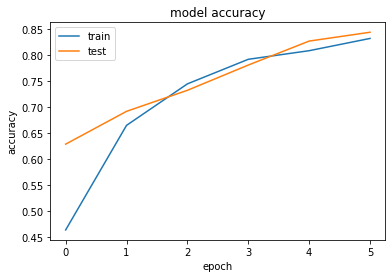

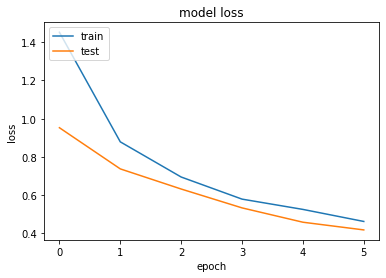

time: 310 ms


In [ ]:
# list all data in history
print(hist.keys())

# summarize history for accuracy
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.ylim(0, 1)
#plt.xlim(0, 70)  # adjust the right leaving left unchanged
plt.show()

# summarize history for loss
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.ylim(1, 3)
#plt.xlim(0, 90)   # adjust the right leaving left unchanged
plt.show()

In [ ]:
!rm -rf saved_models
CATARACT_SAVED_MODEL = "saved_models/cataract"
model.save(CATARACT_SAVED_MODEL)
#model.save('saved_model.h5')
cataract_model = tf.keras.models.load_model(CATARACT_SAVED_MODEL,custom_objects={'KerasLayer':hub.KerasLayer})
#cataract_model = tf.keras.models.load_model('saved_model.h5')



#tf.keras.experimental.export_saved_model(model, CATARACT_SAVED_MODEL)
# cataract_model = tf.keras.experimental.load_from_saved_model(CATARACT_SAVED_MODEL,
# custom_objects={'KerasLayer':hub.KerasLayer})

INFO:tensorflow:Assets written to: saved_models/cataract/assets


INFO:tensorflow:Assets written to: saved_models/cataract/assets


time: 8.45 s


In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)
time: 435 ms


In [ ]:
tf_model_predictions = cataract_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


Idle  ...  Phacoemulsification_General
0  3.18e-02  ...                         0.16
1  3.64e-03  ...                         0.98
2  5.26e-02  ...                         0.66
3  1.82e-02  ...                         0.88
4  6.07e-03  ...                         0.87

[5 rows x 4 columns]

time: 529 ms


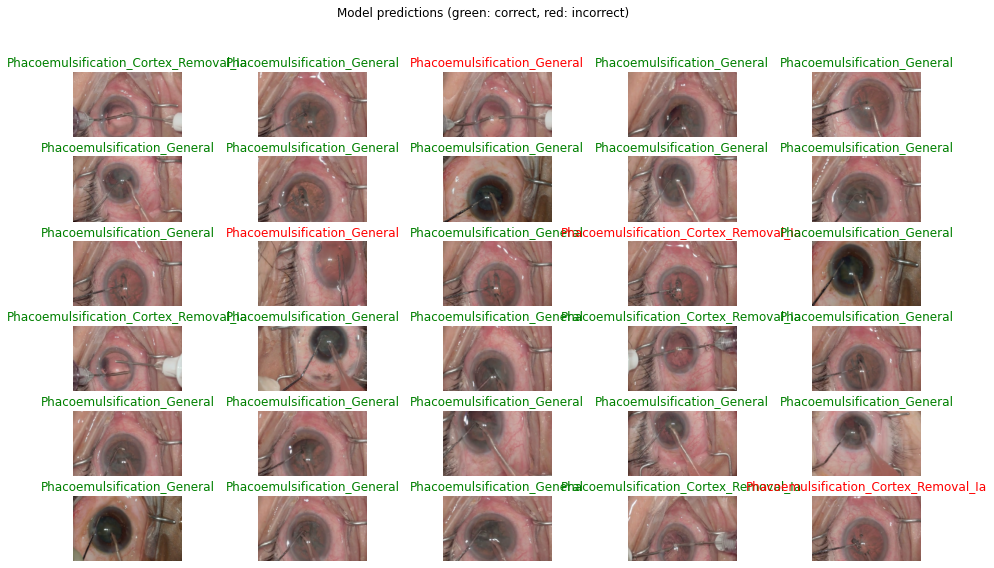

time: 1.42 s


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

plt.figure(figsize=(16,9))
plt.subplots_adjust(hspace=0.3)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n], aspect = '0.6')
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
#export model files for local use
!zip -r model.zip saved_models/cataract/


updating: saved_models/cataract/ (stored 0%)
updating: saved_models/cataract/assets/ (stored 0%)
updating: saved_models/cataract/saved_model.pb (deflated 92%)
updating: saved_models/cataract/variables/ (stored 0%)
updating: saved_models/cataract/variables/variables.data-00000-of-00002 (deflated 88%)
updating: saved_models/cataract/variables/variables.index (deflated 79%)
updating: saved_models/cataract/variables/variables.data-00001-of-00002 (deflated 7%)
time: 2.2 s


In [ ]:
#function to predict a single frame inside google colab
import cv2
from google.colab.patches import cv2_imshow
image_load = cv2.imread('test_pred.png')
image = cv2.resize(image_load, (224, 224))
cv2_imshow(image)
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
single_prediction = cataract_model.predict(image)
print(single_prediction)
idx = single_prediction.argmax(axis=-1)
print(dataset_labels[idx])